<a href="https://colab.research.google.com/github/SoniaBorsi/Adversarial-Attack-GNN/blob/metattack/metattack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [1]:
# !pip uninstall -y torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv deeprobust
#!pip uninstall -y numpy
#!pip install numpy==1.23.5

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 

In [1]:
!pip install numpy torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install deeprobust
!pip install networkx matplotlib

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
# Import the required modules
import torch
import torch_geometric
import deeprobust

print("✅ PyTorch Version:", torch.__version__)
print("✅ PyG Installed:", torch_geometric.__version__)

import torch.nn.functional as F
import numpy as np

print("✅ Numpy Installed:", np.__version__)

import networkx as nx
import matplotlib.pyplot as pl

✅ PyTorch Version: 2.0.0+cu117
✅ PyG Installed: 2.6.1
✅ Numpy Installed: 1.23.5


In [3]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from deeprobust.graph.global_attack import Metattack

print("✅ Metattack Imported Successfully")

from torch_geometric.utils import to_scipy_sparse_matrix
from torch_sparse import from_scipy

# Planetoid: Cora, Citeseer, PubMed
# WebKB: Texas
# PolBlogs: polblogs
from torch_geometric.datasets import Planetoid, WebKB, PolBlogs, Flickr
# OGB: ogbn-proteins
#from ogb.graphproppred import PygGraphPropPredDataset

✅ Metattack Imported Successfully


# Load Datasets
Cora, Citeseer, PubMed, Texas, PolBlogs, and Flickr

In [4]:
# Load the datasets. Throw an error if the dataset is not recognized.

def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    return Planetoid(root=f"./data/{name}", name=name)[0]
  elif name in ["Texas"]:
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name in ["PolBlogs"]:
    return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name in ["Flickr"]:
    return Flickr(root=f"./data/Flickr")[0]
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "Flickr": load_dataset("Flickr")
}

Processing...
Done!
Processing...
Done!
Processing...
Done!
Extracting tmp/polblogs/raw/polblogs.tar.gz
Processing...
Done!
Processing...
Done!
Processing...
Done!


# Define GCN Model

In [80]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.gc1 = GCNConv(num_features, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, num_classes)

        self.nfeat = num_features
        self.nclass = num_classes
        self.hidden_sizes = [hidden_channels]
        self.with_relu = True

    @property
    def gc1_weight(self):
        return self.gc1.lin.weight

    @property
    def gc2_weight(self):
        return self.gc2.lin.weight

    @property
    def weight(self):
        return self.gc1.lin.weight

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, edge_index)
        self.output = x
        return x

# Train GCN Model

In [81]:
def train_model(model, data, epochs=100, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return model


# Metattack Over All Datasets

In [88]:
import scipy.sparse as sparse

def apply_metattack(model, data, num_perturbations):
  adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes).tocsr()
  features = sparse.csr_matrix(data.x.numpy())
  labels = data.y.numpy()

  idx_train = data.train_mask.nonzero(as_tuple=True)[0].cpu().numpy()
  idx_unlabeled = (~data.train_mask).nonzero(as_tuple=True)[0].cpu().numpy()

  attacker = Metattack(
      model=model,
      nnodes=data.num_nodes,
      attack_structure=True,
      attack_features=False,
      device='cpu'
  )

  attacker.attack(
      features,
      adj,
      labels,
      idx_train,
      idx_unlabeled,
      n_perturbations=num_perturbations,
      ll_constraint=False  # This avoids the sparse tensor issue
  )

  return attacker.modified_adj, attacker.modified_features

# Evaluate Model

In [107]:
def evaluate_model(model, data, perturbed_adj, perturbed_features):
  # Check the type of perturbed_adj
  print(type(perturbed_adj))

  # Ensure the adjacency matrix is in sparse COO format
  if not perturbed_adj.is_sparse:
        perturbed_adj = perturbed_adj.to_sparse()

  # Get edge_index directly from the sparse tensor (COO format)
  edge_index = perturbed_adj._indices()

  # Ensure the features are in the right format
  perturbed_x = torch.tensor(perturbed_features.toarray(), dtype=torch.float)

  # Forward pass through the model using the perturbed graph and features
  model.eval()
  with torch.no_grad():
        out = model(perturbed_x, edge_index)

  pred = out.argmax(dim=1)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
  acc = correct / data.test_mask.sum().item()

  return acc

# Visualization

In [99]:
import matplotlib.pyplot as plt

def visualize_graph(edge_index, title="Graph"):
  if isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.cpu().numpy()

  if edge_index.shape[0] != 2:
    raise ValueError("Expected edge_index shape [2, num_edges]")

  # Convert to list of edge tuples
  edge_list = list(zip(edge_index[0], edge_index[1]))

  G = nx.Graph()
  G.add_edges_from(edge_list)
  plt.figure(figsize=(8, 6))
  nx.draw(G, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
  plt.title(title)
  plt.show()

# Run Experiments

In [109]:
from torch_geometric.data import Data

def run_experiment(dataset_name):
  dataset = load_dataset(dataset_name)

  if isinstance(dataset, Data):
    # If it is already a Data object
    data = dataset

    #print(f"Data Keys: {data.keys()}")  # Check the keys of the data object
    num_classes = len(torch.unique(data.y)) # Infer number of classes from the labels 'y'

    print("=" * 100)
    print(f"Dataset: {dataset_name}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of features: {data.num_features}")
    print(f"Number of classes: {num_classes}\n")

    model = GCN(data.num_features, 16, num_classes)
    model = train_model(model, data)

    print("-" * 100)
    print("Original Graph")

    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")
    perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=5)

    edge_index_perturbed = perturbed_adj.nonzero().t()

    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

    # Get the accuracy
    acc = evaluate_model(model, data, perturbed_adj, perturbed_features)
    print(f"Accuracy after Metattack on {dataset_name}: {acc:.4f}")

  else:
    # If its a dataset that needs to be indexed (like Planetoid)
    data = dataset[0]

    num_classes = len(torch.unique(data.y))

    print("=" * 100)
    print(f"Dataset: {dataset_name}")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of features: {data.num_features}")
    print(f"Number of classes: {data.num_classes}\n")

    model = GCN(data.num_features, 16, num_classes)
    model = train_model(model, data)

    print("-" * 100)
    print("Original Graph")
    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")
    perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=5)

    edge_index_perturbed = perturbed_adj.nonzero().t()

    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

    # Get the accuracy
    acc = evaluate_model(model, data, perturbed_adj, perturbed_features)
    print(f"Accuracy after Metattack on {dataset_name}: {acc:.4f}")


# Execution

Dataset: Cora
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch 0, Loss: 1.9398
Epoch 10, Loss: 0.7511
Epoch 20, Loss: 0.2477
Epoch 30, Loss: 0.1194
Epoch 40, Loss: 0.0554
Epoch 50, Loss: 0.0510
Epoch 60, Loss: 0.0293
Epoch 70, Loss: 0.0421
Epoch 80, Loss: 0.0450
Epoch 90, Loss: 0.0430
----------------------------------------------------------------------------------------------------
Original Graph


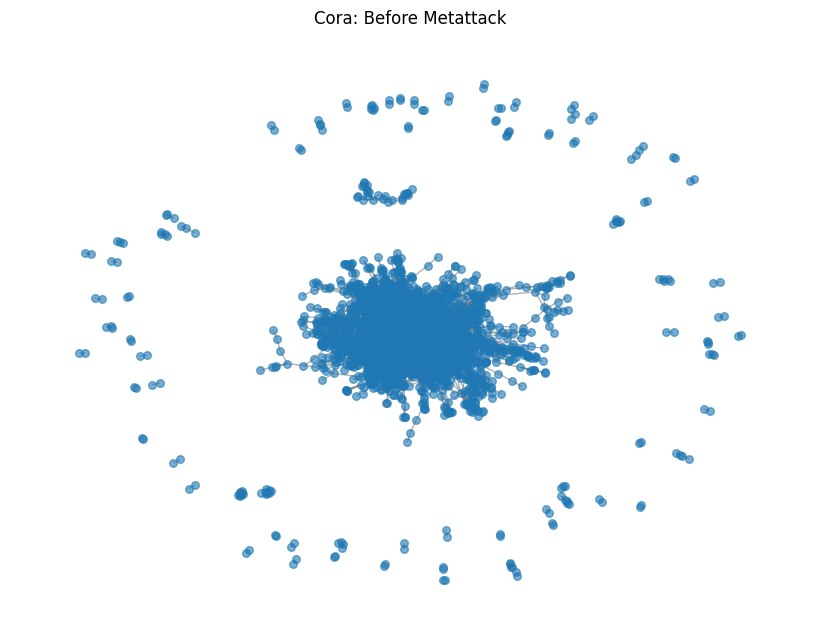

Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.6663058400154114
GCN acc on unlabled data: 0.7866043613707165
attack loss: 0.3183985650539398


Perturbing graph:  20%|██        | 1/5 [00:13<00:55, 13.77s/it]

GCN loss on unlabled data: 0.6760217547416687
GCN acc on unlabled data: 0.7986760124610592
attack loss: 0.30715084075927734


Perturbing graph:  40%|████      | 2/5 [00:28<00:42, 14.08s/it]

GCN loss on unlabled data: 0.702056348323822
GCN acc on unlabled data: 0.785436137071651
attack loss: 0.3257295787334442


Perturbing graph:  60%|██████    | 3/5 [00:43<00:29, 14.56s/it]

GCN loss on unlabled data: 0.7186741828918457
GCN acc on unlabled data: 0.7912772585669782
attack loss: 0.32215559482574463


Perturbing graph:  80%|████████  | 4/5 [00:58<00:14, 14.83s/it]

GCN loss on unlabled data: 0.6861698627471924
GCN acc on unlabled data: 0.7881619937694704
attack loss: 0.3212960958480835


Perturbing graph: 100%|██████████| 5/5 [01:12<00:00, 14.50s/it]


Perturbed Graph
----------------------------------------------------------------------------------------------------


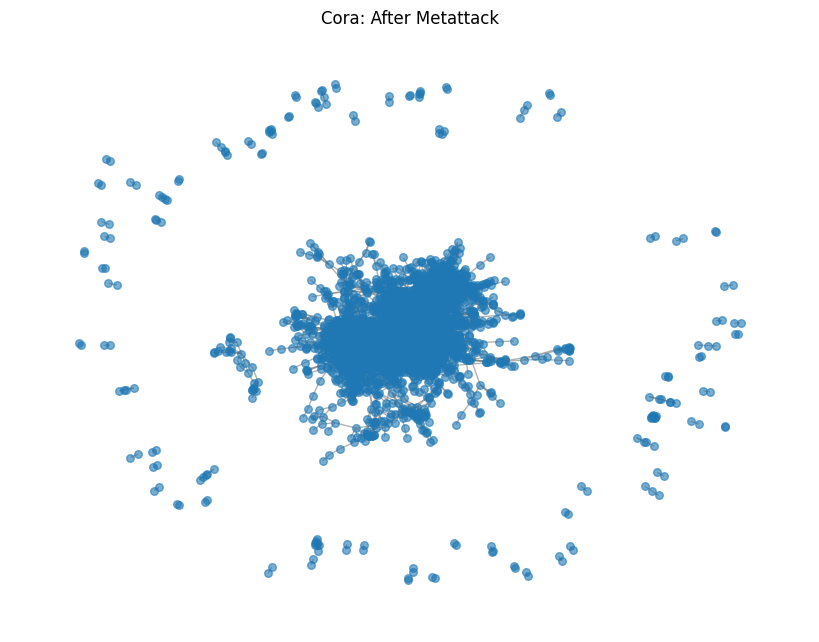

<class 'torch.Tensor'>


AttributeError: 'NoneType' object has no attribute 'toarray'

In [108]:
datasets = ["Cora", "Citeseer", "PubMed", "PolBlogs", "Texas", "Flickr"]

for dataset_name in datasets:
  run_experiment(dataset_name)